## TODO
class vehicle movement predictor
put vehicle to x0,y0,a0 and rotate all the points
receive vehicle north and host point


In [1]:
print('test')

test


## Cameras

In [2]:
from src.vision import Camera

mba_video_camera = Camera(
    h_fov=59.0,
    h_res=1080,
    v_res=720,
)

mba_photo_camera = Camera(
    h_fov=67.0,
    h_res=1290,
    v_res=720,
)

zed_two_camera = Camera(
    h_fov=110.0,
    v_fov=70.0,
)

avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [3]:
from src.point import Point

ref_points = [
    Point(0, 0),
    Point(1200, 0),
    Point(2200, 0),
    Point(4200, 0),
    Point(3000, 1280),
    Point(3995, 1590),
    Point(3005, -1150),
    Point(4000, -1490),
]
print(ref_points)


[Point(x=0, y=0, a=None), Point(x=1200, y=0, a=None), Point(x=2200, y=0, a=None), Point(x=4200, y=0, a=None), Point(x=3000, y=1280, a=None), Point(x=3995, y=1590, a=None), Point(x=3005, y=-1150, a=None), Point(x=4000, y=-1490, a=None)]


In [4]:
from IPython.display import clear_output

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import time

import torch



## YOLOv8 For human and objects detection

First attempt at human positioning with YOLOv8. Unsure if will be usefull because of the RGBD camera. It lets us estimates the angle between the camera and the person. Could also be usefull for object detection and avoidance. 

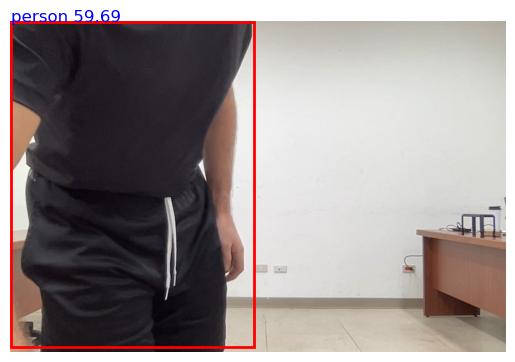

In [11]:
from src.vision import VideoCapture
from src.vision import ObjectDetector
from src.vision import plot_obj
from ultralytics import YOLO
from src.vision import ReID


yolo_model = YOLO('yolov8s.pt')
obj_detector = ObjectDetector(yolo_model, mba_video_camera)
camera = mba_video_camera

try:
    # Initiate the camera
    # cap = VideoCapture('./Movie on 2023-11-23 at 10.03.mov')
    cap = VideoCapture('./Movie on 2023-12-11 at 21.01.mov')
    # cap = VideoCapture(0)
    time.sleep(0.5)

    cap.skip_frames(14)
    frame = cap.grab_frame()
    obj_detector.detect(frame)
    host = obj_detector.get_objs_by_name('person', score=0.4).iloc[0]
    reid = ReID(frame, host, 16)

    while True:
        cap.skip_frames(14)
        frame = cap.grab_frame()
        if frame is None:
            break
        
        obj_detector.detect(frame)
        objs = obj_detector.get_objs_by_name('person', score=0.4)
        # objs = obj_detector.get_objs()

        reid_rmse = []
        for index, obj in objs.iterrows():
            rmse = reid.reid_score(frame, obj)
            reid_rmse.append(rmse)
        objs['rmse'] = reid_rmse

        min_rmse = objs['rmse'].min()
        if min_rmse < 110:
            host = objs[objs['rmse'] == min_rmse].iloc[0]
            objs = objs[objs['rmse'] != min_rmse]

        clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.imshow(frame)

        plot_obj(ax, host, 'r') if min_rmse < 110 else None
        for index, obj in objs.iterrows():
            plot_obj(ax, obj, 'y')

        plt.axis('off')
        plt.show()
        
        # Frame rate
        # plt.pause(0.15)

except KeyboardInterrupt:
    cap.release()  # Release the camera resource

cap.release()  # Release the camera resource if break